# Introductory Notes about Multithreading and Multiprocessing

- ## What's a thread and a process?
A thread is the basic unit of execution within a process. It is an independent flow of execution that shares the same address space as other independent flows of execution within the same process. A process can have one or more threads, one of them is the main thread, which is the default thread of a Python process

- ## What's the difference between multithreading and multiprocessing?
- **Multithreading** : Many Threads , One CPU core , Shared memory space
- **Multiprocessing** : Many Processes , Many CPU cores , Each process has its own memory space

- ## When to use multithreading and multiprocessing?
- **Multithreading** : Use when you have I/O bound tasks
- **Multiprocessing** : Use when you have CPU bound tasks

- ## What's the Global Interpreter Lock (GIL)?
The GIL is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once. It prevents threads from using multiple CPU cores. It is necessary because CPython is not thread-safe.


- ## Benfits of Multithreading 
![Benefits of Multithreading Over Sequential Execution](./Benefits_of_multithreading.png)

## Example 1 : 1 Thread I/O + 1 Thread CPU Bound

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt

# def get_saving_path(path: str) -> str:
#     cwd = os.path.dirname(os.path.realpath(__file__))
#     return os.path.join(cwd, path)


def postprocess_times(times: list[tuple[float]]) -> tuple[list[float]]:
    """Remove the start time of the first task from all tasks so
    that the overall start time is 0. Then split the start and end
    points to make it easier to represent later."""
    init_time = times[0][0]

    start_points, end_points = list(), list()
    for interval in times:
        start_points.append(interval[0] - init_time)
        end_points.append(interval[1] - init_time)

    return start_points, end_points


def flaten_list_of_lists(times: list[list]) -> tuple[list[float]]:
    return [time for time_list in times for time in time_list]

def barh(
    title: str,
    start_points: list[float],
    end_points: list[float],
    path: str,
    n: int = 10,
    secs: int = 11,
    color=(0.2, 0.65, 1, 0.8),
) -> None:

    with plt.style.context("dark_background"):
        plt.figure(figsize=(10, 4.5))

        plt.barh(
            range(n),
            left=start_points,
            width=np.array(end_points) - np.array(start_points),
            color=color,
            align="center",
        )

        plt.title(title)
        plt.ylabel("tasks")
        plt.xlabel("time (in secs)")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.yticks(range(n))
        plt.xticks(range(secs))

    plt.savefig(path)

In [2]:
import logging
from threading import Thread
from time import perf_counter, sleep


format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")


shared_list = []  # threads from the same process share data


def io_bound_operation(secs: float | int) -> None:
    """Run 1 I/O-bound task of secs seconds and append the results to shared_list."""
    start = perf_counter()
    sleep(secs)
    finish = perf_counter()

    shared_list.append([(start, finish)])


def cpu_bound_operation(n: int) -> None:
    """CPU-bound task."""
    start = perf_counter()
    count = 0
    for i in range(n):
        count += i
    finish = perf_counter()

    shared_list.append([(start, finish)])

In [3]:
def threading_two_threads(save_path: str):
    # Create two thread objects
    t1 = Thread(target=io_bound_operation, args=(1,))
    t2 = Thread(target=cpu_bound_operation, args=(100000000,))

    # Start activity -> invokes run() method
    t1.start()
    sleep(0.1)
    t2.start()

    # Block the calling thread -> Avoids continuing to run without threads
    # being finished
    t1.join()
    t2.join()

    logging.info(f"shared_list {shared_list}")
     
    # Just some processing for chart
    start_points, end_points = postprocess_times(flaten_list_of_lists(shared_list))
    
    barh(
        title="Concurrent execution, 2 threads, 1 I/O-bound task of 1s + 1 \
               CPU-task of 3.5s approx",
        start_points=start_points,
        end_points=end_points,
        path=save_path,
        n=2,
    )

16:14:23: Init concurrent tasks
16:14:30: shared_list [[(525093.5147012, 525094.5267018)], [(525093.6150777, 525099.72742)]]
16:14:30: Finish concurrent tasks


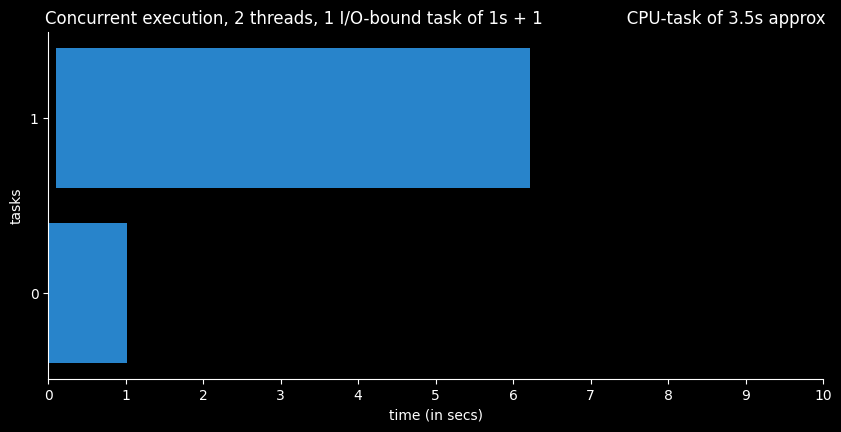

In [4]:
logging.info("Init concurrent tasks")
threading_two_threads("./Example_1.png")
logging.info("Finish concurrent tasks")